# U ResNet for 5 particle segmentation

In this notebook, I set up and train UResNet for 5 particle classification on the DeepLearnPhysics open data sets.

In [1]:
BATCH_SIZE = 4
NUM_LABELS = 6 # (background, electron, muon, photon, pion, proton)
N_INITIAL_FILTERS = 32
NETWORK_DEPTH = 4
BALANCE_LOSS = True
LOGDIR = './uresnet_five_particle/'
BASE_LEARNING_RATE = 0.001
TRAINING=True
labels_names = ['background', 'electron', 'muon', 'photon', 'proton', 'pion']

## Looking at the data

First things first, let's take a look at the data.  We'll use the larcv dataloader2 functionality to open up the data and look at it, similar to [this blog post](http://deeplearnphysics.org/Blog/2018-01-05-TrainingSegmentationData_v0.1.0.html#2018-01-05-TrainingSegmentationData_v0.1.0 "DeepLearnPhysics Blog: Semantic Segmentation")

In [2]:
# Larcv imports:
import ROOT
from larcv import larcv
larcv.ThreadProcessor
from larcv.dataloader2 import larcv_threadio

# Misc python imports:
import numpy
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import os,sys,time

# tensorflow/gpu start-up configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2
import tensorflow as tf



Welcome to JupyROOT 6.08/06
env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [61]:
from tensorflow.python.client import device_lib
print device_lib.list_local_devices()
default_device = "/cpu:0"

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11841408363733365794
]


Get an instance of the train data loader to load some images:

In [4]:
# Dump the contents of the config file:
with open('train_io.cfg', 'r') as f:
    s = ""
    for line in f.readlines(): 
        s += line
    print s

TrainIO: {
  Verbosity:       3
  EnableFilter:    false
  RandomAccess:    2
  RandomSeed:      0
  InputFiles:      ["/data/LARTPC_INDP/practice_train_2k.root"]
  ProcessType:     ["Cluster2DThreshold","MultiPartSegFromCluster2dParticle","BatchFillerImage2D","BatchFillerImage2D"]
  ProcessName:     ["Cluster2DThreshold","MultiPartSegFromCluster2dParticle","main_data","main_label"]
  NumThreads:      4
  NumBatchStorage: 4

  ProcessList: {
    main_data: {
      Verbosity: 3
      ImageProducer: "data"
      Channels: [0]
    }
    main_label: {
      Verbosity: 3
      ImageProducer: "mcst_multip"
      Channels: [0]
    }
    Cluster2DThreshold: {
      Cluster2DProducer:  "mcst"
      OutputProducer:     "mcst_threshold"
      Threshold:          0.2
    }
    MultiPartSegFromCluster2dParticle: {
      Cluster2dProducer: "mcst_threshold"
      OutputProducer:    "mcst_multip"
      ParticleProducer:  "mcst"
      Image2dProducer:   "data"
      PdgClassList:      [11,-11,13,-13,22

In [5]:
train_io = larcv_threadio()
train_io_cfg = {'filler_name' : 'TrainIO',
                'verbosity'   : 0, 
                'filler_cfg'  : 'train_io.cfg'}
train_io.configure(train_io_cfg)

 setting verbosity 3


For just looking at the data, start the manager with just one event:

In [6]:
train_io.start_manager(4)


Fetch some data so we can look at it:

In [7]:
data = train_io.fetch_data('main_data')
label = train_io.fetch_data('main_label')

In [8]:
print "Data dimensions: {}".format(data.dim())
print "Label dimensions: {}".format(label.dim())

Data dimensions: None
Label dimensions: None


Let's visualize these images:

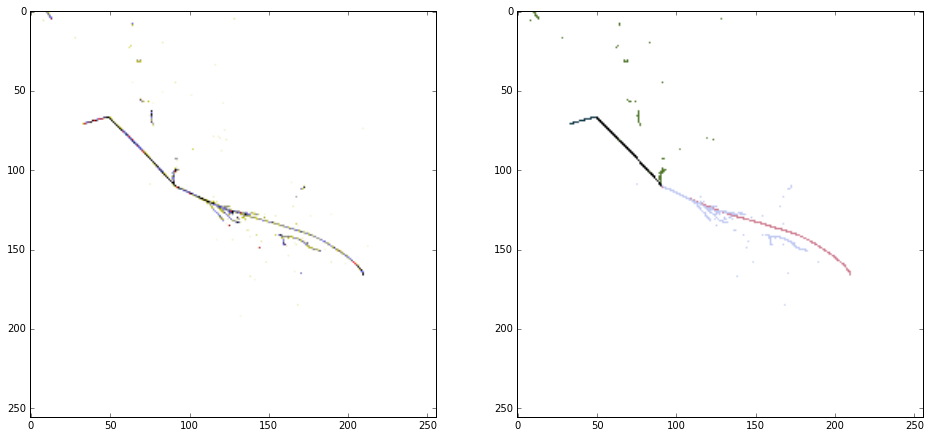

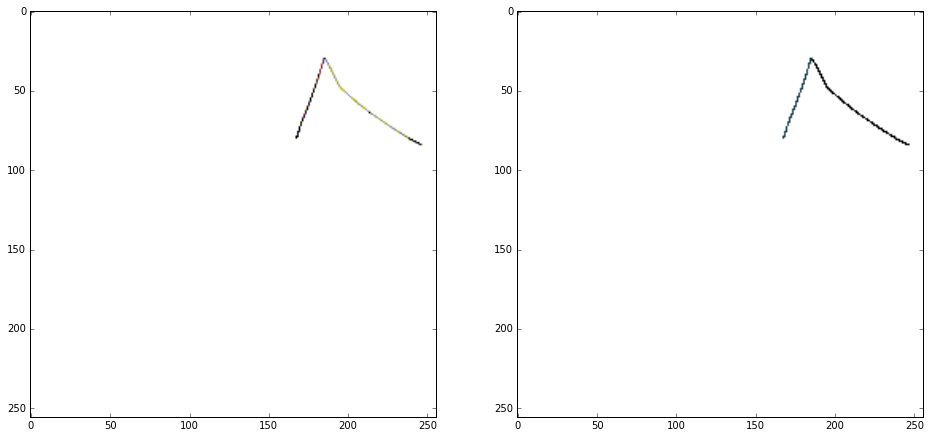

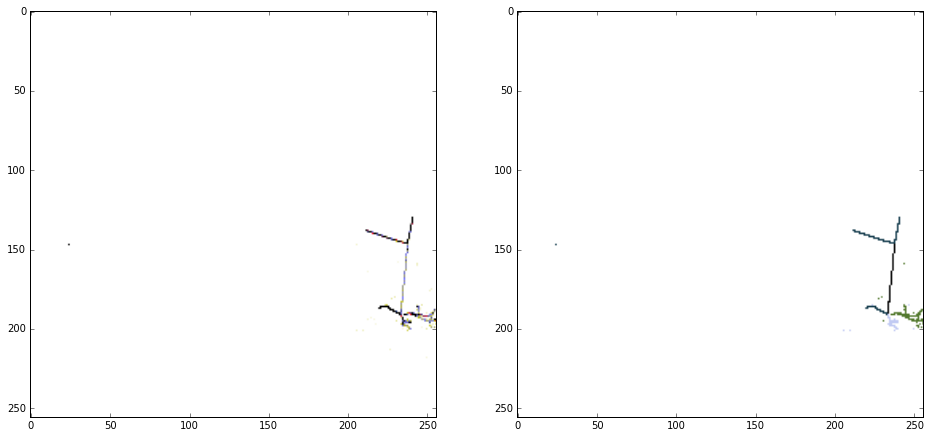

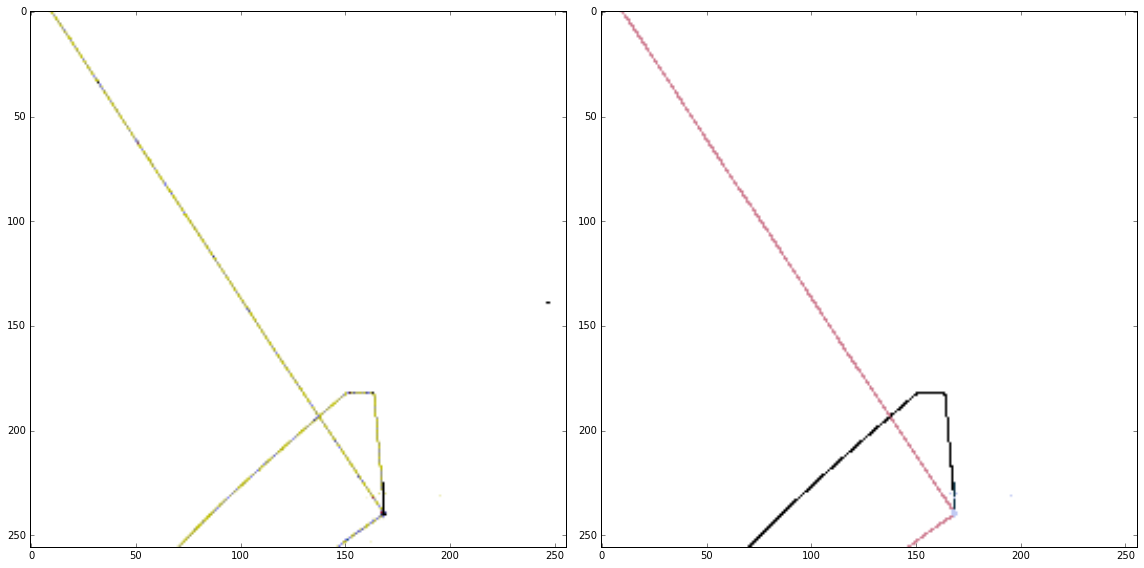

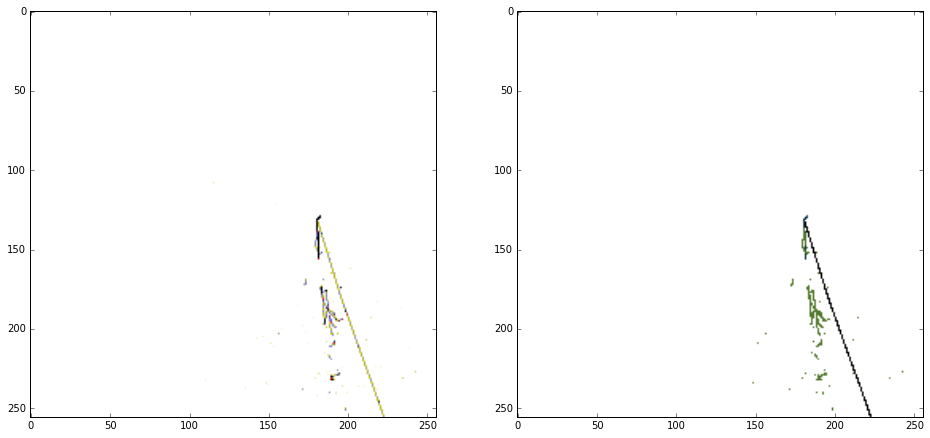

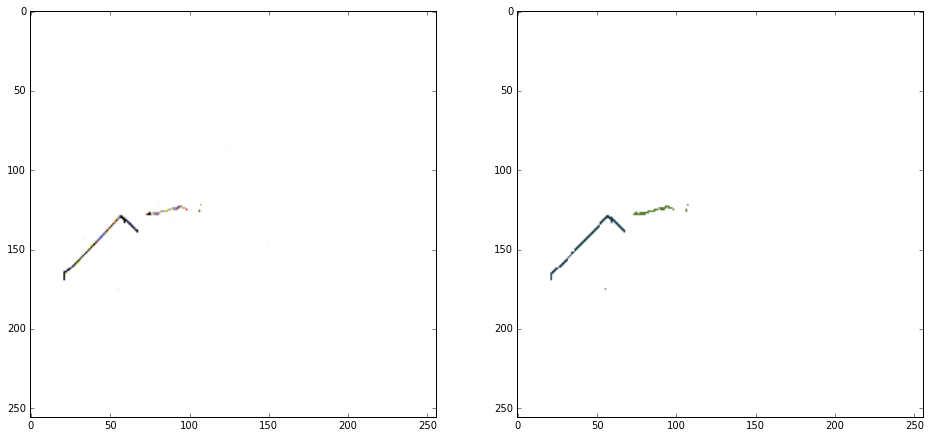

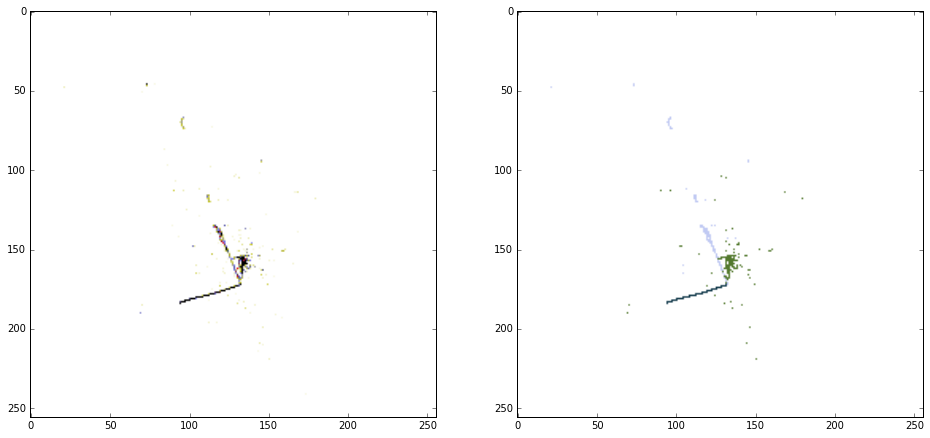

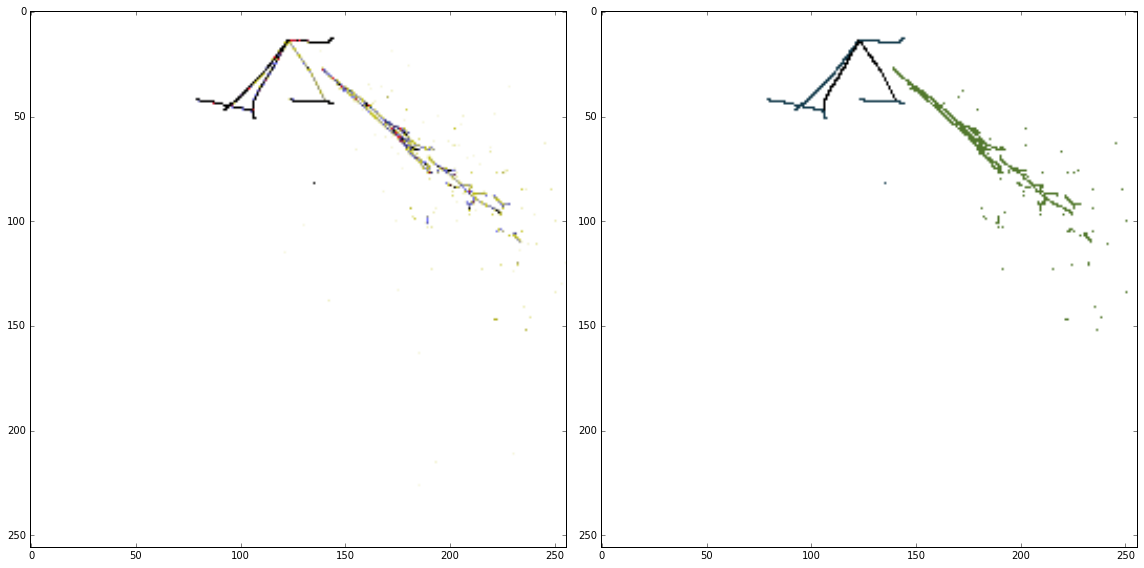

In [18]:
for i in xrange(2):
    # Load new data:
    train_io.next()

    while train_io.is_reading():
        time.sleep(0.1)

    # Fetch the data and reshape it:
    plt_data   = numpy.reshape(train_io.fetch_data("main_data").data(), (BATCH_SIZE, 256, 256))
    label_arr = numpy.reshape(train_io.fetch_data("main_label").data(), (BATCH_SIZE, 256, 256))

    for batch in range(BATCH_SIZE):
        f, axarr = plt.subplots(1,2, figsize=(16, 8))
        axarr[0].imshow(plt_data[batch], vmin=0, vmax=300, cmap='gist_stern_r')
        axarr[1].imshow(label_arr[batch],vmin=0, vmax=5, cmap='cubehelix_r')

    plt.tight_layout()
    plt.show()


## Setting up a network

From the images above, you can get a sense of the task to come.  We'll use a residual version of UNet for this, and there are useful functions defined in the utils class for implementing this:

In [19]:
from utils import residual_block, downsample_block, upsample_block

The first step of set up is to define placeholders for the input:

In [38]:
def init_inputs(graph, device, data, label):
    with graph.as_default(), tf.device(device):
        input_image  = tf.placeholder(tf.float32, data.dim(), name="input_image")
        input_labels = tf.placeholder(tf.int64, label.dim(), name="input_image")
        
        # Squeeze the last index off of the labels:
        
        return input_image, tf.squeeze(input_labels, axis=-1)

In [21]:
# Next, make the network graph intialization:

In [22]:
def build_network(graph, device, input_image, training):
    with graph.as_default(), tf.device(device):
        
        x = input_image
        
        # Initial convolution to get to the correct number of filters:
        x = tf.layers.conv2d_transpose(x, N_INITIAL_FILTERS,
                             kernel_size=[5, 5],
                             strides=[1, 1],
                             padding='same',
                             use_bias=False,
                             trainable=training,
                             name="Conv2DInitial",
                             reuse=None)

        # ReLU:
        x = tf.nn.relu(x)
        
        # Need to keep track of the outputs of the residual blocks before downsampling, to feed 
        # On the upsampling side
        
        network_filters = []

        # Begin the process of residual blocks and downsampling:
        for i in xrange(NETWORK_DEPTH):
            
            x = residual_block(x, training,
                               batch_norm=False,
                               name="resblock_down_{0}".format(i))
        
            network_filters.append(x)
            x = downsample_block(x, training,
                                batch_norm=False,
                                name="downsample_{0}".format(i))
        
        
        # At the bottom, do another residual block:
        x = residual_block(x, training, batch_norm=False, name="deepest_block")
        
        # Come back up the network:
        for i in xrange(NETWORK_DEPTH-1, -1, -1):
            
            # How many filters to return from upsampling?
            n_filters = x.get_shape().as_list()[-1]
            
            
            # Upsample:
            x = upsample_block(x, training, batch_norm=False,n_output_filters=n_filters, name="upsample_{}".format(i))
            
            
            x = tf.concat([x, network_filters[-1]], axis=-1, name='up_concat_{}'.format(i))
            
            # Remove the recently concated filters:
            network_filters.pop()
            

            # Residual
            x = residual_block(x, training,
                               batch_norm=False,
                               name="resblock_up_{0}".format(i))
        
        # At this point, we ought to have a network that has the same shape as the initial input, but with more filters.
        # We can use a bottleneck to map it onto the right dimensions:
        x = tf.layers.conv2d(x,
                             NUM_LABELS,
                             kernel_size=[1,1],
                             strides=[1, 1],
                             padding='same',
                             activation=None,
                             use_bias=False,
                             trainable=training,
                             name="BottleneckConv2D",)
        
        # The final activation is softmax across the pixels.  It gets applied in the loss function
#         x = tf.nn.softmax(x)
        return x

### Loss functions

Here we'll define the loss for this training, which is a softmax cross entropy

In [23]:
def loss(labels, logits, graph, device):
    with tf.device(device), graph.as_default(), tf.name_scope('cross_entropy'):
        
        # For this application, since background pixels heavily outnumber labeled pixels, we can weight 
        # the loss to balance things out.
        if BALANCE_LOSS:
            weight  = tf.size(labels) / tf.cast(tf.count_nonzero(labels), tf.int32)
            weights = tf.where(labels==0, x=1, y=weight)
            losses  = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels, logits, weights=weights))
        else:
            # Compute the loss without balancing:
            losses = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels, logits))
        
        # Add the loss to the summary:
        tf.summary.scalar("Total_Loss", losses)
        
        return losses

### Accuracy computation

It's useful to compute the accuracy (overall, and also on only the non-background labels)

In [52]:
def accuracy(labels, logits, graph, device):
    with tf.device(device), graph.as_default(), tf.name_scope('accuracy'):
        total_accuracy   = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, axis=-1), 
                                                           labels), tf.float32))
        predicted_labels = tf.argmax(logits, axis=-1)
        # Find the non zero labels:
        non_zero_indices = tf.not_equal(labels, tf.constant(0, labels.dtype))
        
        non_zero_logits = tf.boolean_mask(predicted_labels, non_zero_indices)
        non_zero_labels = tf.boolean_mask(labels, non_zero_indices)
        
        non_bkg_accuracy = tf.reduce_mean(tf.cast(tf.equal(non_zero_logits, non_zero_labels), tf.float32))

        # Add the accuracies to the summary:
        tf.summary.scalar("Total_Accuracy", total_accuracy)
        tf.summary.scalar("Non_Background_Accuracy", non_bkg_accuracy)

### Optimizer

For this optimizer, we don't need anything complicated:

In [40]:
def optimizer(loss, graph, device):
    with tf.device(device), graph.as_default(), tf.name_scope('training'):
        global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
        
        opt = tf.train.AdamOptimizer(BASE_LEARNING_RATE).minimize(loss, global_step = global_step)
        return opt

### Snapshotting

One essential piece of monitoring training is to snapshot along the way to understand how the network is doing.  Let's make snapshots of images per label type

In [58]:
def snapshot(labels, logits, graph, device):
    with tf.device(device), graph.as_default(), tf.name_scope('snapshot'):
        # There are 5 labels plus background pixels available:
        predicted_label = tf.argmax(logits, axis=-1)
        for label in xrange(len(labels_names)):
            target_img = tf.cast(tf.equal(labels, tf.constant(label, labels.dtype)), tf.uint8)
            output_img = tf.cast(tf.equal(predicted_label, tf.constant(label, labels.dtype)), tf.uint8)
            tf.summary.image('{}_labels'.format(labels_names[label]), target_img)
            tf.summary.image('{}_logits'.format(labels_names[label]), output_img)            

### Merge all summaries:

Put together all of the summaries into one object and create a writer

In [59]:
def summary(graph, device):
    with tf.device(device), graph.as_default():
        merged_summary = tf.summary.merge_all()

        # Set up a saver:
        train_writer = tf.summary.FileWriter(LOGDIR)
        return train_writer, merged_summary


### Put the network together

Combine all of the above functions to build the full tensorflow graph

In [60]:
# Reset the graph:
tf.reset_default_graph()

g = tf.Graph()
# First, get the input placeholders:
images, labels = init_inputs(g, default_device, train_io.fetch_data("main_data"), train_io.fetch_data("main_label"))

# Apply UResNet to the image to get the logits:
logits = build_network(g, default_device, images, training=TRAINING)

losses = loss(labels, logits, g, default_device)

accuracy(labels, logits, g, default_device)
opt = optimizer(losses, g, default_device)
snapshot(labels, logits, g, default_device)
writer, merged_summary = summary(g, default_device)


## Training the network

Define a function to handle training of the network for one iteration

In [ ]:
def train_step(input_placeholder, label_placeholder, optimizer, summary, writer, train_io, sess):
    
    # First step, prepare the feed dict:
    train_io.next()
    fd = {input_placeholder : train_io.fetch_data("main_data").data(),
          label_placeholder : train_io.fetch_data("main_label").data()}
    
    _, summary = sess.run([optimizer, summary], feed_dict = fd)
    
    writer.add_summary(summary)